<a href="https://colab.research.google.com/github/newmantic/UMAP/blob/main/UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.sparse import coo_matrix
from scipy.optimize import curve_fit

In [2]:
class UMAP:
    def __init__(self, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components = n_components
        self.metric = metric

    def _find_neighbors(self, X):
        distances = pairwise_distances(X, metric=self.metric)
        knn_indices = np.argsort(distances, axis=1)[:, 1:self.n_neighbors+1]
        knn_distances = np.sort(distances, axis=1)[:, 1:self.n_neighbors+1]
        return knn_indices, knn_distances

    def _fuzzy_simplicial_set(self, knn_indices, knn_distances, n_samples):
        rows = np.repeat(np.arange(n_samples), self.n_neighbors)
        cols = knn_indices.flatten()
        vals = np.exp(-knn_distances.flatten())
        W = coo_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))
        W = W + W.T - W.multiply(W.T)
        return W

    def _embed(self, graph, n_epochs=200, learning_rate=1.0):
        n_vertices = graph.shape[0]
        embedding = np.random.normal(0, 0.0001, size=(n_vertices, self.n_components))

        for epoch in range(n_epochs):
            for i in range(n_vertices):
                neighbors = graph.getrow(i).indices
                for j in neighbors:
                    if i == j:
                        continue
                    dist = np.sum((embedding[i] - embedding[j])**2)
                    grad = 2.0 * (dist - self.min_dist) * (embedding[i] - embedding[j])
                    embedding[i] -= learning_rate * grad

        return embedding

    def fit_transform(self, X):
        n_samples = X.shape[0]

        # Step 1: Find nearest neighbors
        knn_indices, knn_distances = self._find_neighbors(X)

        # Step 2: Build fuzzy simplicial set
        graph = self._fuzzy_simplicial_set(knn_indices, knn_distances, n_samples)

        # Step 3: Optimize low-dimensional representation
        embedding = self._embed(graph)
        return embedding

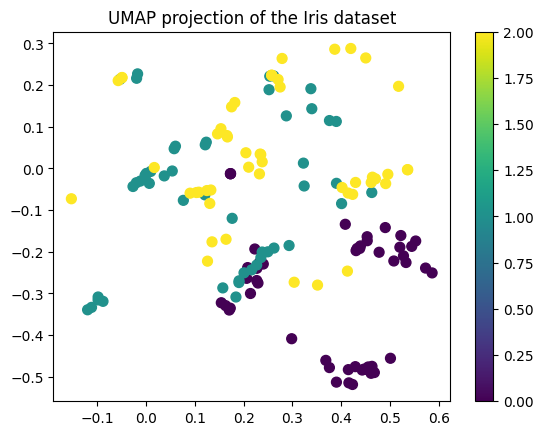

In [3]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Initialize UMAP
umap = UMAP(n_neighbors=10, min_dist=0.1, n_components=2)

# Fit and transform data
embedding = umap.fit_transform(X)

# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar()
plt.title('UMAP projection of the Iris dataset')
plt.show()